## Core Workflow: Query Feature layer
Purpose: Load albedo prediction for different years from ArcGIS online and query them. The queries can be performed on whole LA county or on a subset area based on user input geometry. The user can upload either a geojson file or a shapefile to define area of interest. The area of the user input geometry must be less than 70 square miles for the code to work. The user can further limit their query using filter for roof albedo, building footprint area and building use type. Some summary statistics are generated initially based on preset criteria where the filter properties are preset by the developer. Some summary statistics are generated at the end based on user defined criteria where the user has more flexibility to set filters for different properties 
<br>
*Date: 2019-12-16*

### Import libraries

In [23]:
from IPython.display import display
import arcgis
from arcgis import GIS
from arcgis.geometry import Geometry

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import mean
import statistics
import fiona
import json
import shapely
from shapely.geometry import shape, Point
from shapely.geometry import mapping, Polygon

import pyproj
from shapely.ops import transform
from functools import partial

import warnings
warnings.filterwarnings('ignore')


### Input parameters

In [24]:
# Set which year to query
query_year = '2014'

# pass input geometry name
inp_shp = 'NeighborhoodCouncils_4326.geojson'

# declare input shape type (geojson or shapefile)
inp_shp_type = 'geojson'

# cooridnate system of the input shape. It must be epsg:4326
inp_crs = 'epsg:4326'

### Make connection to ArcGIS online

In [25]:
# connect to your GIS without signing in
gis = GIS("https://www.arcgis.com")

### Search for all the prediction layers from ArcGIS online

In [26]:
webmap_search = gis.content.search("prediction_LA_cnty_LA_cnty_2009", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2009 = LA_map_item.layers[0]

webmap_search = gis.content.search("prediction_LA_cnty_LA_cnty_2012", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2012 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2014", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2014 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2016", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2016 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2018", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2018 = LA_map_item.layers[0]

In [27]:
if query_year == '2009':
    LA_layer = LA_layer_2009
elif query_year == '2012':
    LA_layer = LA_layer_2012
elif query_year == '2014':
    LA_layer = LA_layer_2014
elif query_year == '2016':
    LA_layer = LA_layer_2016
elif query_year == '2018':
    LA_layer = LA_layer_2018

### Load the user input geometry

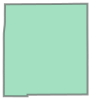

In [28]:
if inp_shp_type == 'geojson':
    with open(inp_shp) as f:
        js = json.load(f)

    arg_list = js['features']
    geom =  arg_list[0]['geometry']
    geom = Geometry(geom)
    s = shape(geom)
    
elif inp_shp_type == 'shapefile':
    inp_shape = load_shape(inp_shp)
    geom = inp_shape.get('geometry')
    geom = Geometry(geom)
    s = shape(inp_shape.get('geometry'))

# plot the user input geomtery    
geom

### Project the user input geomtery to epsg:32611 (meter coordinate system)

In [29]:
proj = partial(pyproj.transform, pyproj.Proj(init=inp_crs),
               pyproj.Proj(init='epsg:32611'))

s_new = transform(proj, s)

projected_area = transform(proj, s).area
projected_area_sqm = projected_area*3.86102e-7 # convert area to square miles
print('Total area of the given geometry in square miles= ',projected_area_sqm)

Total area of the given geometry in square miles=  2.548398969612342


In [30]:
# create the filter geometry
aoi = arcgis.geometry.filters.intersects(geom)

In [31]:
# query a feature layer for features that meet filter criteria
queried_layer = LA_layer.query(geometry_filter=aoi)

### Save the queried layer as a pandas dataframe

In [32]:
df = queried_layer.sdf
df

,FID,roof_no,use_type,shape_area,albedo,Shape__Area,Shape__Length,SHAPE
0,1522925,1546140,Commercial,321.489526,0.063286,468.875000,86.788101,"{'rings': [[[-13166713.660457, 4025426.1618195..."
1,1525085,1549308,Residential,32.560798,0.193935,47.476562,27.715825,"{'rings': [[[-13166847.1430875, 4024299.218075..."
2,1525357,1547754,Residential,143.554515,0.175064,209.367188,61.925614,"{'rings': [[[-13165124.1593589, 4025347.934965..."
3,1525369,1547755,Industrial,1518.711717,0.151536,2215.527344,213.090488,"{'rings': [[[-13164895.2675852, 4026791.986497..."
4,1525380,1547756,Residential,155.590149,0.112142,226.886719,67.406001,"{'rings': [[[-13166492.4632543, 4024527.372949..."
...,...,...,...,...,...,...,...,...
12468,2064775,2064745,Residential,298.679027,0.175775,435.582031,116.289024,"{'rings': [[[-13164417.1729971, 4025161.043609..."
12469,2064790,2064746,Residential,119.614121,0.069473,174.441406,58.131127,"{'rings': [[[-13165934.4794471, 4025042.887766..."
12470,2064796,2064747,Residential,133.301199,0.097137,194.382812,77.974733,"{'rings': [[[-13166310.3418244, 4024437.349193..."
12471,2064867,2064749,Residential,32.535660,0.138797,47.460938,27.877372,"{'rings': [[[-13165651.5938107, 4026499.834281..."


In [33]:
# albedo column is saved as different name in name file. Fix the name here
if query_year == '2009' or '2012':
    df.rename(columns={'Scored_Lab': 'albedo','shp_area': 'shape_area'}, inplace=True)

match_area = df['shape_area'].sum(axis=0)

rfs_mu = round(df['albedo'].mean(axis=0),4)
rfs_sigma = round(df['albedo'].std(axis=0),4)

In [34]:
# functions for loading shapefile, percentage calculation and histogram
def load_shape(place_shapefile):
    c = fiona.open(place_shapefile)
    pol = c.next()
    shape = {}
    shape['type'] = pol['type']
    shape['properties'] = pol['properties']
    shape['geometry'] = {}
    shape['geometry']['type'] = 'Polygon'  # pol['geometry']['type']
    shape['geometry']['coordinates'] = [[]]
    # if MultiPolygon (e.g., city='kampala')
    if (len(pol['geometry']['coordinates'])>1):
        # identify largest single polygon
#         print("MultiPolygon", len(pol['geometry']['coordinates']))
        p_argmax = 0 
        pn_max = 0
        for p in range(len(pol['geometry']['coordinates'])):
            pn = len(pol['geometry']['coordinates'][p][0])
            if pn>pn_max:
                p_argmax = p
                pn_max = pn
#             print(p, pn, p_argmax, pn_max )
        # make largest polygon the only polygon, move other polys to a backup variable 
        polygon = pol['geometry']['coordinates'][p_argmax]
    else:
#         print('simple polygon')
        polygon = pol['geometry']['coordinates']
       
    xmin =  180
    xmax = -180
    ymin =  90
    ymax = -90
    for x,y in polygon[0]:
        xmin = xmin if xmin < x else x
        xmax = xmax if xmax > x else x
        ymin = ymin if ymin < y else y
        ymax = ymax if ymax > y else y
        shape['geometry']['coordinates'][0].append([x,y])
    shape['bbox'] = [xmin,ymin,xmax,ymax]
    
    return shape

def percentage(part, whole):
  return 100 * float(part)/float(whole)

def plot_histogram(dataframe):
    dataframe['ScoredLabels']=dataframe['albedo']
    x = dataframe.ScoredLabels.dropna()
    plt.figure(figsize=(9,9))
    N, bins, patches = plt.hist(x,bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 
                                    0.8, 0.85,0.9,0.95,1])

    cmap = plt.get_cmap('jet')
    low = cmap(0.5)
    medium =cmap(0.2)
    high = cmap(0.7)


    for i in range(0,1):
        patches[i].set_facecolor('#d7191c')
    for i in range(1,2):
        patches[i].set_facecolor('#e9603d')
    for i in range(2,3):
        patches[i].set_facecolor('#fca75d')
    for i in range(3,4):
        patches[i].set_facecolor('#fed189')
    for i in range(4,5):
        patches[i].set_facecolor('#fff8b6')
    for i in range(5,6):
        patches[i].set_facecolor('#eef8c8')
    for i in range(6,7):
        patches[i].set_facecolor('#d9eed3')
    for i in range(7,8):
        patches[i].set_facecolor('#c3e4dd')
    for i in range(8,9):
        patches[i].set_facecolor('#addae8')
    for i in range(9,10):
        patches[i].set_facecolor('#85b9d2')
    for i in range(10,11):
        patches[i].set_facecolor('#5a96b8')
    for i in range(11,12):
        patches[i].set_facecolor('#2f729d')
    for i in range(12,18):
        patches[i].set_facecolor('#054e83')

    plt.grid()    
    plt.xlabel("Predicted Albedo", fontsize=16)  
    plt.ylabel("Count of Roofs", fontsize=16)
    plt.axvline(x.mean(), color='#544f50', linestyle='dashed', linewidth=1)
    plt.xticks(np.arange(0, 1.01, 0.05),fontsize=8)   

    ax = plt.subplot(111)  

    mu = round(dataframe.loc[:,"albedo"].mean(),4)
    sigma = round(dataframe.loc[:,"albedo"].std(),4)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(1, 1, textstr, verticalalignment='top', horizontalalignment='right',transform=ax.transAxes, style='italic',fontsize=8)

    plt.show()


### Query based on pre-set criteria

In [35]:
# Threshold for different roof size
sm_rf_thrs = 500       # threshold for small roof
md_rf_lo_thrs = 500    # lower threshold for medium roof
md_rf_up_thrs = 5000   # upper threshold for medium roof
lg_rf_thrs = 5000      # threshold for large roof

In [36]:
# list of small, medium and large roof areas
small_roofs = df.loc[(df['shape_area'] <= sm_rf_thrs)]
s_rfs_ar = small_roofs['shape_area'].sum(axis=0)
s_rfs_mu = round(small_roofs['albedo'].mean(axis=0),4)
s_rfs_sigma = round(small_roofs['albedo'].std(axis=0),4)

medium_roofs = df.loc[(df['shape_area'] > md_rf_lo_thrs) & (df['shape_area'] <= md_rf_up_thrs)]
m_rfs_ar = medium_roofs['shape_area'].sum(axis=0)
m_rfs_mu = round(medium_roofs['albedo'].mean(axis=0),4)
m_rfs_sigma = round(medium_roofs['albedo'].std(axis=0),4)

large_roofs = df.loc[(df['shape_area'] >= lg_rf_thrs)]
l_rfs_ar = large_roofs['shape_area'].sum(axis=0)
l_rfs_mu = round(large_roofs['albedo'].mean(axis=0),4)
l_rfs_sigma = round(large_roofs['albedo'].std(axis=0),4)

# find the count of small and large roofs 
cnt_small_roofs = len(small_roofs)
cnt_medium_roofs = len(medium_roofs)
cnt_large_roofs = len(large_roofs)

### Summary Statistics based on pre-set criteria

Total area of the given geometry =  6600325.74 square meters
Total area of roofs within the given geometry =  2001027.85 square meters
Total count of roofs within the given geometry =  12473
Mean albedo of roofs within the given geometry =  0.1316
Standard deviation for albedo of roofs within the given geometry =  0.075

Number of small roofs (roofs with area less than 500 m2) =  12100
Total area of small roofs =  1286149.96 square meters
Percentage of small roofs on total area =  64.27 %
Mean albedo of small roofs within the given geometry =  0.1291
Standard deviation for albedo of small roofs within the given geometry =  0.0713

Number of medium roofs (roofs with area between 500 m2 and 5000 m2) =  355
Total area of medium roofs =  502489.36 square meters
Percentage of medium roofs on total area =  25.11 %
Mean albedo of medium roofs within the given geometry =  0.2104
Standard deviation for albedo of medium roofs within the given geometry =  0.126

Number of large roofs (roofs with 

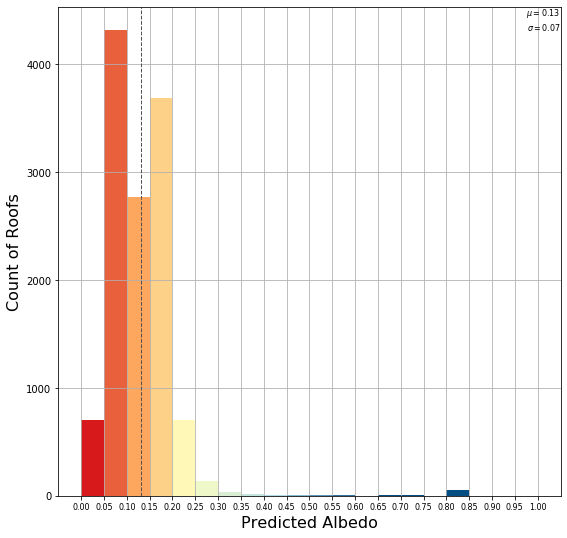

Histogram of albedos for small roofs in 2014 within the AOI


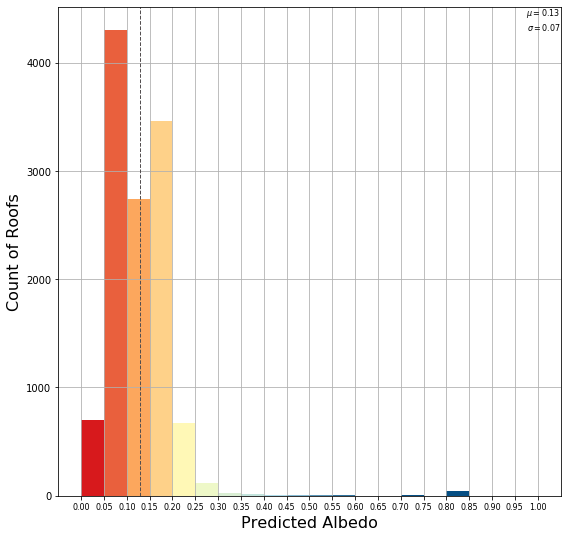

Histogram of albedos for medium roofs in 2014 within the AOI


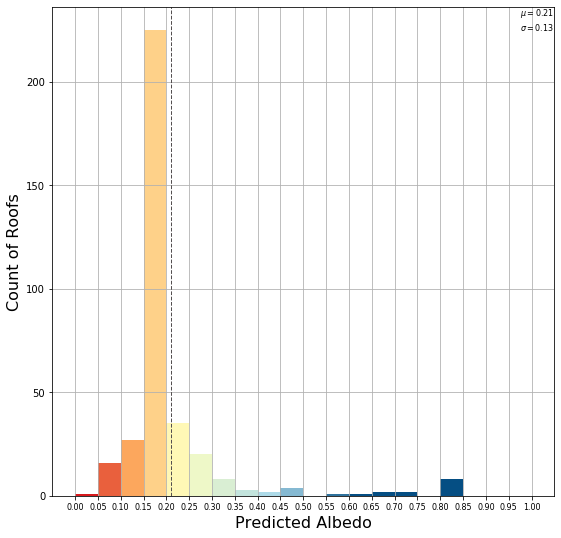

Histogram of albedos for large roofs in 2014 within the AOI


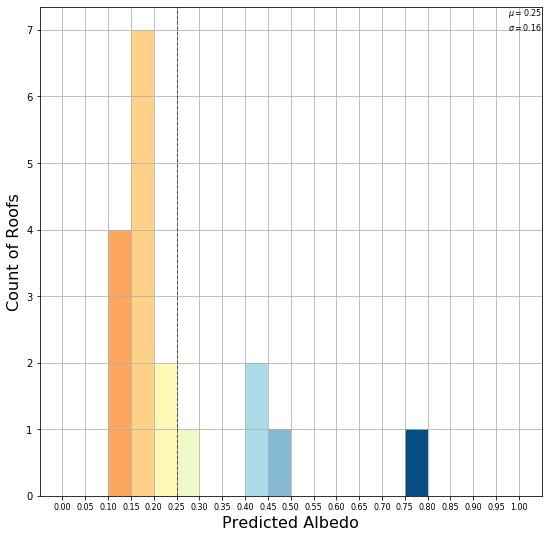

In [37]:
print('Total area of the given geometry = ', round(projected_area,2), 'square meters')
print('Total area of roofs within the given geometry = ', round((match_area),2), 'square meters') 
print('Total count of roofs within the given geometry = ', df.shape[0])
print('Mean albedo of roofs within the given geometry = ', rfs_mu)
print('Standard deviation for albedo of roofs within the given geometry = ', rfs_sigma)
print()
print('Number of small roofs (roofs with area less than', sm_rf_thrs, 'm2) = ', cnt_small_roofs)
print('Total area of small roofs = ', round((s_rfs_ar),2), 'square meters')
print('Percentage of small roofs on total area = ', round(percentage((s_rfs_ar),(match_area)),2), '%')
print('Mean albedo of small roofs within the given geometry = ', s_rfs_mu)
print('Standard deviation for albedo of small roofs within the given geometry = ', s_rfs_sigma)
print()
print('Number of medium roofs (roofs with area between',md_rf_lo_thrs,'m2 and',md_rf_up_thrs,'m2) = ', cnt_medium_roofs)
print('Total area of medium roofs = ', round((m_rfs_ar),2), 'square meters')
print('Percentage of medium roofs on total area = ', round(percentage((m_rfs_ar),(match_area)),2), '%')
print('Mean albedo of medium roofs within the given geometry = ', m_rfs_mu)
print('Standard deviation for albedo of medium roofs within the given geometry = ', m_rfs_sigma)
print()
print('Number of large roofs (roofs with area larger than',lg_rf_thrs,'m2) = ', cnt_large_roofs)
print('Total area of large roofs = ', round((l_rfs_ar),2), 'square meters')
print('Percentage of large roofs on total area = ', round(percentage((l_rfs_ar),(match_area)),2), '%')
print('Mean albedo of large roofs within the given geometry = ', l_rfs_mu)
print('Standard deviation for albedo of large roofs within the given geometry = ', l_rfs_sigma)
print()

print('Histogram of albedos for all roofs in ' +query_year+ ' within the AOI')
plot_histogram(df)
print('Histogram of albedos for small roofs in ' +query_year+ ' within the AOI')
plot_histogram(small_roofs)
print('Histogram of albedos for medium roofs in ' +query_year+ ' within the AOI')
plot_histogram(medium_roofs)
print('Histogram of albedos for large roofs in ' +query_year+ ' within the AOI')
plot_histogram(large_roofs)

--------------------------------------------

### Query based on user defined criteria

In [38]:
# Set the range for roof albedo between 0 and 1
# lower bound
lo_bnd_rf_alb = 0 
# Upper bound
up_bnd_rf_alb = 1

In [39]:
# Set the range for building footprint area 
# lower bound
lo_bnd_rf_ar = 0 
# Upper bound
up_bnd_rf_ar = 100000

In [40]:
# available_use_types = ['Commercial','Government','Industrial','Institutional','Irrigated Farm','Miscellaneous',
#                        'Recreational','Residential']

# Set which building use type you want to query on from the above available use types
set_use_type = ['Commercial','Residential']

In [41]:
us_def_roofs = df.loc[(df['albedo'] > lo_bnd_rf_alb) & (df['albedo'] <= up_bnd_rf_alb)]
us_def_roofs = us_def_roofs.loc[(us_def_roofs['shape_area'] > lo_bnd_rf_ar) & (us_def_roofs['shape_area'] <= up_bnd_rf_ar)]
us_def_roofs = us_def_roofs[us_def_roofs['use_type'].isin(set_use_type)]
us_def_rfs_ar = us_def_roofs['shape_area'].sum(axis=0)
us_def_rfs_mu = round(us_def_roofs['albedo'].mean(axis=0),4)
us_def_rfs_sigma = round(us_def_roofs['albedo'].std(axis=0),4)

# find the count of small and large roofs 
cnt_us_def_roofs = len(us_def_roofs)


### Summary Statistics based on user defined criteria

User Criteria: albedo range is between  0 and  1 ; Building footprint area is between  0 m2 and  100000 m2 ; Building use type are  ['Commercial', 'Residential']

Number of roofs based on user criteria =  11629
Total area of roofs =  502489.36 square meters
Percentage of roofs on total area =  25.11 %
Mean albedo of roofs within the given geometry =  0.2104
Standard deviation for albedo of roofs within the given geometry =  0.126

Histogram of albedos for all roofs in 2014 within the AOI and based on user filter


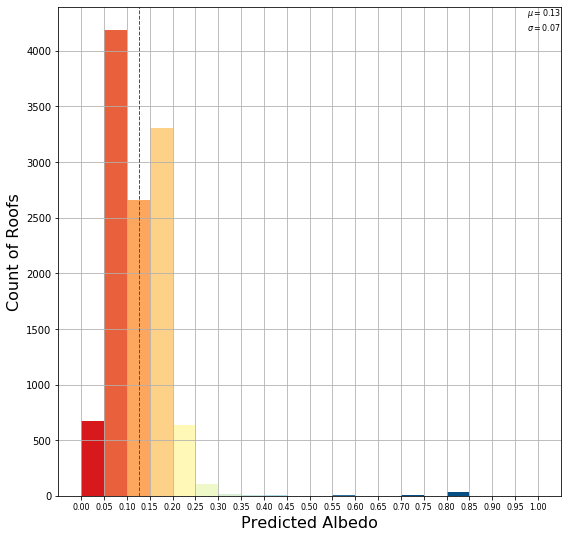

In [42]:
print('User Criteria: albedo range is between ', lo_bnd_rf_alb, 'and ', up_bnd_rf_alb,
                   '; Building footprint area is between ', lo_bnd_rf_ar, 'm2 and ', up_bnd_rf_ar,'m2',
                '; Building use type are ', set_use_type)
print()
print('Number of roofs based on user criteria = ', cnt_us_def_roofs)
print('Total area of roofs = ', round((m_rfs_ar),2), 'square meters')
print('Percentage of roofs on total area = ', round(percentage((m_rfs_ar),(match_area)),2), '%')
print('Mean albedo of roofs within the given geometry = ', m_rfs_mu)
print('Standard deviation for albedo of roofs within the given geometry = ', m_rfs_sigma)
print()

print('Histogram of albedos for all roofs in ' +query_year+ ' within the AOI and based on user filter')
plot_histogram(us_def_roofs)

---------------------------------------